# Time Constraints and Dependencies: The Foundation of Scheduling

This notebook demonstrates a fundamental aspect of scheduling: **time constraints** and **dependencies** that cannot be violated.

Understanding time constraints is critical because:
- Time cannot be stretched, compressed, or ignored
- Dependencies create sequences that must be respected
- Violating time constraints makes schedules **infeasible** (impossible to execute)
- Time constraints create cascading effects throughout the schedule


## Key Concepts

**Time Constraints** are hard boundaries:
- Deadlines: tasks must finish by a specific time
- Time windows: tasks can only occur within specific periods
- Durations: tasks take a fixed amount of time
- Cannot be violated without making the schedule infeasible

**Dependencies** define sequences:
- Task A must finish before Task B can start
- Create chains of tasks that must happen in order
- Violating dependencies makes schedules impossible to execute

**Critical Path** is the sequence of tasks that determines minimum schedule duration:
- The longest path through dependent tasks
- Any delay on the critical path delays the entire schedule
- Tasks not on the critical path have "slack" (flexibility)

**Critical insight**: Time constraints and dependencies are non-negotiable. A schedule that violates them is not suboptimal—it is impossible.


## Scenario: Software Development Project

You are managing a software development project with multiple tasks that have dependencies. The project must be completed within 20 working days.

**Tasks and their durations**:
- Design: 5 days
- Development: 10 days (requires Design to complete)
- Testing: 5 days (requires Development to complete)
- Documentation: 3 days (can start after Design, but must finish before release)
- Deployment: 2 days (requires Testing and Documentation to complete)

**Dependencies**:
- Development → depends on Design
- Testing → depends on Development
- Documentation → can start after Design (but independent of Development)
- Deployment → depends on both Testing AND Documentation

**Challenge**: Can this project be completed in 20 days? What is the critical path?


## Step 1: Install Required Packages (Colab)

If you're running this notebook in Google Colab, you may need to install packages. This cell can be skipped if running locally and packages are already installed.


In [1]:
# Install required packages if needed (for Google Colab)
# Can be skipped if already installed locally
%pip install matplotlib pandas networkx -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime, timedelta
import networkx as nx


## Step 3: Define Tasks and Dependencies


In [3]:
# Define tasks with their durations (in days)
tasks = {
    'Design': 5,
    'Development': 10,
    'Testing': 5,
    'Documentation': 3,
    'Deployment': 2
}

# Define dependencies: (predecessor, successor)
# Format: (task that must finish, task that can start)
dependencies = [
    ('Design', 'Development'),
    ('Design', 'Documentation'),  # Documentation can start after Design
    ('Development', 'Testing'),
    ('Testing', 'Deployment'),
    ('Documentation', 'Deployment')  # Deployment needs both Testing AND Documentation
]

print("TASKS AND DURATIONS:")
print("=" * 50)
for task, duration in tasks.items():
    print(f"  {task:15s}: {duration} days")

print("\nDEPENDENCIES:")
print("=" * 50)
for pred, succ in dependencies:
    print(f"  {pred} → {succ}")


TASKS AND DURATIONS:
  Design         : 5 days
  Development    : 10 days
  Testing        : 5 days
  Documentation  : 3 days
  Deployment     : 2 days

DEPENDENCIES:
  Design → Development
  Design → Documentation
  Development → Testing
  Testing → Deployment
  Documentation → Deployment


## Step 4: Calculate Schedule with Dependencies (Forward Pass)

We'll calculate the earliest start and finish times for each task, respecting dependencies:


In [4]:
# Calculate earliest start and finish times
def calculate_schedule(tasks, dependencies):
    """Calculate earliest start and finish times for all tasks"""
    
    # Initialize: all tasks start at day 0
    earliest_start = {task: 0 for task in tasks.keys()}
    earliest_finish = {task: 0 for task in tasks.keys()}
    
    # Find tasks with no dependencies (can start immediately)
    all_tasks = set(tasks.keys())
    tasks_with_predecessors = {succ for _, succ in dependencies}
    start_tasks = all_tasks - tasks_with_predecessors
    
    # Process tasks in order (simple topological sort)
    processed = set()
    
    def process_task(task):
        if task in processed:
            return
        
        # Find all predecessors
        predecessors = [pred for pred, succ in dependencies if succ == task]
        
        # Process predecessors first
        for pred in predecessors:
            process_task(pred)
        
        # Calculate earliest start: max of all predecessor finish times
        if predecessors:
            earliest_start[task] = max(earliest_finish[pred] for pred in predecessors)
        else:
            earliest_start[task] = 0
        
        # Earliest finish = earliest start + duration
        earliest_finish[task] = earliest_start[task] + tasks[task]
        
        processed.add(task)
    
    # Process all tasks
    for task in tasks.keys():
        process_task(task)
    
    return earliest_start, earliest_finish

# Calculate schedule
earliest_start, earliest_finish = calculate_schedule(tasks, dependencies)

# Create schedule dataframe
schedule_data = []
for task in tasks.keys():
    schedule_data.append({
        'Task': task,
        'Duration': tasks[task],
        'Earliest Start': earliest_start[task],
        'Earliest Finish': earliest_finish[task]
    })

schedule_df = pd.DataFrame(schedule_data)
schedule_df = schedule_df.sort_values('Earliest Start')

print("SCHEDULE WITH DEPENDENCIES:")
print("=" * 70)
display(schedule_df)

total_duration = max(earliest_finish.values())
print(f"\nTotal project duration: {total_duration} days")
print(f"Deadline: 20 days")
print(f"\n{'✓ Project is FEASIBLE' if total_duration <= 20 else '✗ Project is INFEASIBLE (exceeds deadline)'}")


SCHEDULE WITH DEPENDENCIES:


,Task,Duration,Earliest Start,Earliest Finish
0,Design,5,0,5
1,Development,10,5,15
3,Documentation,3,5,8
2,Testing,5,15,20
4,Deployment,2,20,22



Total project duration: 22 days
Deadline: 20 days

✗ Project is INFEASIBLE (exceeds deadline)


In [5]:
# Calculate critical path
def find_critical_path(tasks, dependencies, earliest_start, earliest_finish):
    """Find the critical path (longest path through dependencies)"""
    
    # Work backwards from the finish
    total_duration = max(earliest_finish.values())
    
    # Find tasks that finish at the end
    end_tasks = [task for task, finish in earliest_finish.items() if finish == total_duration]
    
    # Build critical path backwards
    critical_path = []
    
    def trace_back(task):
        if task not in critical_path:
            critical_path.insert(0, task)
            
            # Find predecessors
            predecessors = [pred for pred, succ in dependencies if succ == task]
            
            # If multiple predecessors, choose the one on the critical path
            # (the one whose finish time equals this task's start time)
            for pred in predecessors:
                if earliest_finish[pred] == earliest_start[task]:
                    trace_back(pred)
                    break
    
    # Start from end tasks
    for end_task in end_tasks:
        trace_back(end_task)
    
    return critical_path

critical_path = find_critical_path(tasks, dependencies, earliest_start, earliest_finish)

print("CRITICAL PATH:")
print("=" * 50)
for i, task in enumerate(critical_path):
    arrow = " → " if i < len(critical_path) - 1 else ""
    print(f"{task}{arrow}", end="")
print("\n")

print("Critical path duration:")
critical_duration = sum(tasks[task] for task in critical_path)
print(f"  {critical_duration} days")

print("\nKey Insight:")
print("  - Any delay on the critical path delays the entire project")
print("  - Tasks not on the critical path have 'slack' (can be delayed without affecting project)")


CRITICAL PATH:
Design → Development → Testing → Deployment

Critical path duration:
  22 days

Key Insight:
  - Any delay on the critical path delays the entire project
  - Tasks not on the critical path have 'slack' (can be delayed without affecting project)


## Step 6: Visualize the Schedule (Gantt-Style Chart)


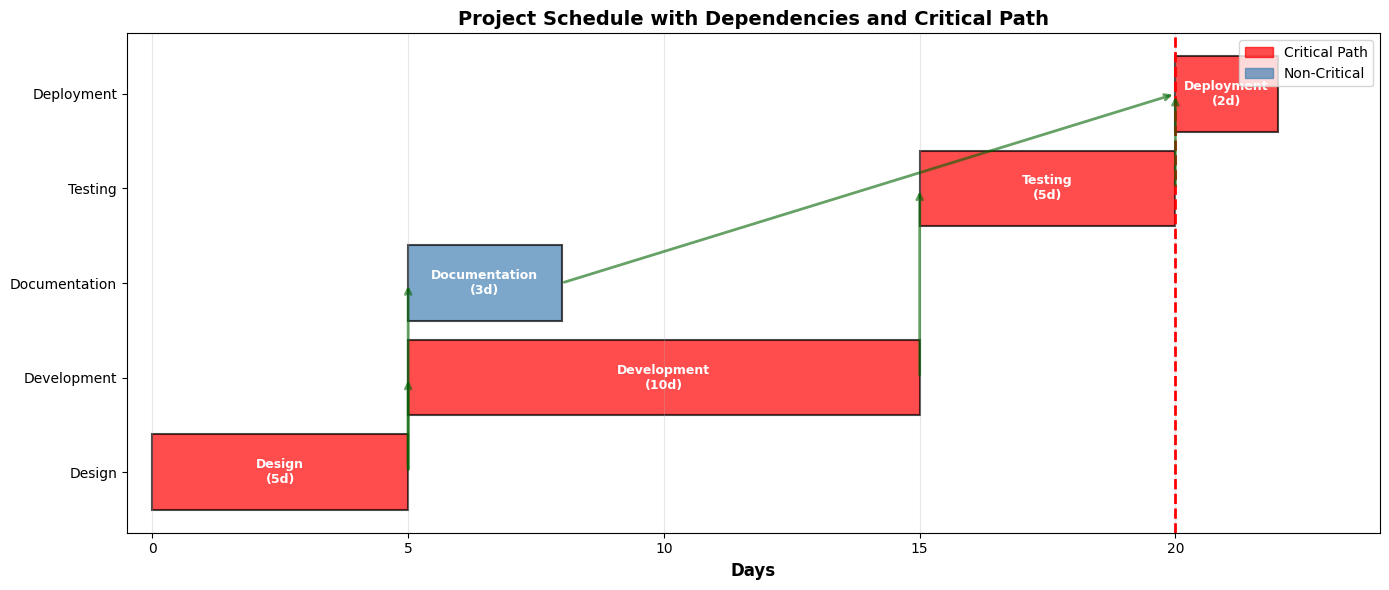


Visualization Key:
  - Red bars: Tasks on critical path (any delay delays project)
  - Blue bars: Non-critical tasks (have slack)
  - Green arrows: Dependencies (predecessor → successor)
  - Red dashed line: Project deadline


In [6]:
# Create Gantt-style visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Colors: critical path in red, non-critical in blue
colors = ['red' if task in critical_path else 'steelblue' for task in schedule_df['Task']]

# Create horizontal bars for each task
y_pos = range(len(schedule_df))

for idx, row in schedule_df.iterrows():
    task = row['Task']
    start = row['Earliest Start']
    duration = row['Duration']
    
    # Draw task bar
    color = 'red' if task in critical_path else 'steelblue'
    ax.barh(y_pos[schedule_df.index.get_loc(idx)], duration, left=start, 
            color=color, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add task label
    ax.text(start + duration/2, y_pos[schedule_df.index.get_loc(idx)], 
            f"{task}\n({duration}d)", ha='center', va='center', 
            fontweight='bold', fontsize=9, color='white')

# Draw dependency arrows
for pred, succ in dependencies:
    pred_idx = schedule_df[schedule_df['Task'] == pred].index[0]
    succ_idx = schedule_df[schedule_df['Task'] == succ].index[0]
    
    pred_finish = schedule_df.loc[pred_idx, 'Earliest Finish']
    succ_start = schedule_df.loc[succ_idx, 'Earliest Start']
    
    pred_y = y_pos[schedule_df.index.get_loc(pred_idx)]
    succ_y = y_pos[schedule_df.index.get_loc(succ_idx)]
    
    # Draw arrow from end of predecessor to start of successor
    ax.annotate('', xy=(succ_start, succ_y), xytext=(pred_finish, pred_y),
                arrowprops=dict(arrowstyle='->', lw=2, color='darkgreen', alpha=0.6))

# Add deadline line
ax.axvline(x=20, color='red', linestyle='--', linewidth=2, label='Deadline (20 days)')

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(schedule_df['Task'])
ax.set_xlabel('Days', fontsize=12, fontweight='bold')
ax.set_title('Project Schedule with Dependencies and Critical Path', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-0.5, max(22, total_duration + 2))

# Legend
critical_patch = mpatches.Patch(color='red', alpha=0.7, label='Critical Path')
non_critical_patch = mpatches.Patch(color='steelblue', alpha=0.7, label='Non-Critical')
ax.legend(handles=[critical_patch, non_critical_patch], loc='upper right')

plt.tight_layout()
plt.show()

print("\nVisualization Key:")
print("  - Red bars: Tasks on critical path (any delay delays project)")
print("  - Blue bars: Non-critical tasks (have slack)")
print("  - Green arrows: Dependencies (predecessor → successor)")
print("  - Red dashed line: Project deadline")


## Step 7: Demonstrate Infeasible Schedule (Violating Dependencies)

What happens if we try to violate a dependency? Let's see what an infeasible schedule looks like:


In [7]:
# Example: What if we try to start Development before Design finishes?
print("EXAMPLE: Violating a Dependency")
print("=" * 70)
print("\nDependency: Design must finish before Development can start")
print(f"  Design duration: {tasks['Design']} days")
print(f"  Design finishes: Day {earliest_finish['Design']}")
print(f"  Development starts: Day {earliest_start['Development']}")
print("\n✓ This schedule RESPECTS the dependency")

print("\n" + "=" * 70)
print("INFEASIBLE SCENARIO: Starting Development on Day 2 (before Design finishes)")
print("=" * 70)
print("\nIf we try to start Development on Day 2:")
print("  - Design is still in progress (finishes Day 5)")
print("  - Development cannot start because Design is not complete")
print("  - This violates the dependency constraint")
print("\n✗ This schedule is INFEASIBLE - cannot be executed")

print("\nKey Insight:")
print("  - Dependencies are HARD constraints")
print("  - Violating them makes schedules impossible to execute")
print("  - No amount of optimization can make an infeasible schedule work")


EXAMPLE: Violating a Dependency

Dependency: Design must finish before Development can start
  Design duration: 5 days
  Design finishes: Day 5
  Development starts: Day 5

✓ This schedule RESPECTS the dependency

INFEASIBLE SCENARIO: Starting Development on Day 2 (before Design finishes)

If we try to start Development on Day 2:
  - Design is still in progress (finishes Day 5)
  - Development cannot start because Design is not complete
  - This violates the dependency constraint

✗ This schedule is INFEASIBLE - cannot be executed

Key Insight:
  - Dependencies are HARD constraints
  - Violating them makes schedules impossible to execute
  - No amount of optimization can make an infeasible schedule work


## Step 8: Demonstrate Cascading Effects

When a task on the critical path is delayed, it cascades through all dependent tasks:


In [8]:
# Demonstrate cascading delay
delay_scenario = {
    'original_duration': tasks['Design'],
    'delayed_duration': tasks['Design'] + 3,  # 3-day delay
    'task': 'Design'
}

print("CASCADING DELAY EXAMPLE")
print("=" * 70)
print(f"\nScenario: {delay_scenario['task']} is delayed by 3 days")
print(f"  Original duration: {delay_scenario['original_duration']} days")
print(f"  Delayed duration: {delay_scenario['delayed_duration']} days")

# Recalculate with delay
delayed_tasks = tasks.copy()
delayed_tasks['Design'] = delay_scenario['delayed_duration']

delayed_start, delayed_finish = calculate_schedule(delayed_tasks, dependencies)
delayed_total = max(delayed_finish.values())

print("\nImpact on dependent tasks:")
print(f"  Design: {delay_scenario['original_duration']}d → {delayed_tasks['Design']}d (+3 days)")
print(f"  Development start: Day {earliest_start['Development']} → Day {delayed_start['Development']} (+{delayed_start['Development'] - earliest_start['Development']} days)")
print(f"  Testing start: Day {earliest_start['Testing']} → Day {delayed_start['Testing']} (+{delayed_start['Testing'] - earliest_start['Testing']} days)")
print(f"  Deployment start: Day {earliest_start['Deployment']} → Day {delayed_start['Deployment']} (+{delayed_start['Deployment'] - earliest_start['Deployment']} days)")

print(f"\nTotal project duration: {total_duration}d → {delayed_total}d (+{delayed_total - total_duration} days)")
print(f"\n{'✓ Still meets deadline' if delayed_total <= 20 else '✗ Now exceeds deadline'}")

print("\nKey Insight:")
print("  - Delays on the critical path cascade to all dependent tasks")
print("  - A small delay can have a large impact on the overall schedule")
print("  - This is why the critical path is so important")


CASCADING DELAY EXAMPLE

Scenario: Design is delayed by 3 days
  Original duration: 5 days
  Delayed duration: 8 days

Impact on dependent tasks:
  Design: 5d → 8d (+3 days)
  Development start: Day 5 → Day 8 (+3 days)
  Testing start: Day 15 → Day 18 (+3 days)
  Deployment start: Day 20 → Day 23 (+3 days)

Total project duration: 22d → 25d (+3 days)

✗ Now exceeds deadline

Key Insight:
  - Delays on the critical path cascade to all dependent tasks
  - A small delay can have a large impact on the overall schedule
  - This is why the critical path is so important


## Summary: Understanding Time Constraints and Dependencies

**Time Constraints** are non-negotiable:
- Deadlines, time windows, and durations create hard boundaries
- Violating time constraints makes schedules infeasible
- Time cannot be stretched or compressed

**Dependencies** create sequences:
- Tasks must happen in a specific order
- Violating dependencies makes schedules impossible to execute
- Dependencies create cascading effects when delays occur

**Critical Path** determines minimum duration:
- The longest sequence of dependent tasks
- Any delay on the critical path delays the entire project
- Tasks not on the critical path have slack (flexibility)

**Practical Implications**:
- Always check that schedules respect all time constraints and dependencies
- Identify the critical path to understand schedule flexibility
- Recognize that infeasible schedules cannot be "fixed" by optimization
- Plan for delays on the critical path, as they have the most impact
